# Screening Analysis

This script addresses the data analysis of screening libraries performed using a Molecular Devices plate reader. The input data should consist of kinetic values from 96-well plates, exported in CSV format from the reader. When naming the plates, ensure to include information such as the substrate, plate number, and type of assay (e.g., activity, stability). The script is designed to support various naming conventions, but it requires manual verification by the researcher to ensure correctness.

**Requirements in Naming**

1- Plate names must include:
1. 1- **Substrate name**,
1. 2- **Assay type (e.g., Thermo, pH...)**
1. 3- **Plate number**. 

2- The script has accommodates 2 classification levels. This mean, if you have thermostability assay conducted at several temperature (3rd level) use as key_word to reduce it to a second level. For instance, if you have assays for ABTS at thermo50 and thermo40, use "thermo40" and "thermo50" as the second classification level to group these assays.
3- Be mindful about spaces; "ph 8" and "pH8" are not considered to be the same.

In [1]:
# Import libraries
import numpy as np            
import pandas as pd
import os
import matplotlib.pyplot as plt  
import re
import string
import itertools
import seaborn as sns

In [3]:
# File Name
file_name = input("Please enter the CSV file name in Data directory(include the .csv extension): ")

# Set up working directory
working_directory = os.getcwd()  # Get the current working directory
file_path = os.path.join(working_directory,"data", file_name)  # Combine the directory and file name

# Upload
try:
    df = pd.read_csv(file_path, delimiter=";")
    print("File successfully loaded")
    print("First few rows of the DataFrame:")
    print(df.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found in the working directory.")
except Exception as e:
    print(f"Error reading the file: {e}")

Please enter the CSV file name (include the .csv extension):  data_test.csv


File successfully loaded
First few rows of the DataFrame:
  ##BLOCKS= 37    Unnamed: 1   Unnamed: 2   Unnamed: 3   Unnamed: 4  \
0       Plate:  ABTS 263 act          1,3  PlateFormat      Kinetic   
1          NaN           NaN            1            2            3   
2          NaN           NaN  158,6621849  257,0319328  211,9159664   
3          NaN           NaN  271,8957983  117,8823529  198,0605042   
4          NaN           NaN  237,4084034   67,3210084  85,79495798   

    Unnamed: 5    Unnamed: 6   Unnamed: 7    Unnamed: 8   Unnamed: 9  ...  \
0   Absorbance       Reduced        FALSE            36          600  ...   
1            4             5            6             7            8  ...   
2  1,966386555   243,7008403  301,4722689   70,10420168  218,7226891  ...   
3  84,55462185    188,702521  273,4386555  -3,620168067  67,58319328  ...   
4  226,1445378  -2,712605042  194,1277311   139,3512605  105,3478992  ...   

   Unnamed: 11  Unnamed: 12  Unnamed: 13 Unnamed: 14

## 1 Assay Set up

This section will clarify the different substrates and assay conditions conducted.


In [4]:
#Directory for relevant information
os.makedirs( os.path.join(os.getcwd(), "Relevant_Data_Frames"), exist_ok=True)

# Extract names in 2nd column and eliminate NaN values
names=list(df.iloc[:,1])
names=[i.lower() for i in names if pd.notna(i)]

# Sort by Substrate, Assay and Plate Number

while True:
    substrate_key=input("Introduce substrate names separate by \",\": ").split(",")
    substrate_key = [s.strip().lower() for s in substrate_key]
    
    print(f"\nSubstrates are: {', '.join(substrate_key)}")
    
    confirm = input("¿Is this correct? (yes/no): ").strip().lower()
    if confirm in ['sí', 'si', 'yes', 'y', "t", "true"]:
        break
    else:
        print("Please, introduce substrates again")
        
        

while True:
    print("\nTo classify assay types, enter keywords that can identify assays throughout the file.")
    print("For example, if you have assays that might be named 'thermo', 'thermostability', 'stability term' in same file, you might use a common name like 'term'.")
    print("In case you don´t, please rename files with a common reference pattern such as Term")
    
    
    assay_keywords = input("Enter assay types separated by commas: ").split(",")
    assay_keywords = [a.strip().lower() for a in assay_keywords]

    # Show assay keywords
    print(f"\nThe assay keywords are: {', '.join(assay_keywords)}")
    
    # Confirm with the user
    confirm = input("Is this correct? (yes/no): ").strip().lower()
    if confirm in ['yes', 'y']:
        break
    else:
        print("Please enter the assay types again.")
        
        
# Classification Function


Introduce substrate names separate by ",":  dmp, abts



Substrates are: dmp, abts


¿Is this correct? (yes/no):  y



To classify assay types, enter keywords that can identify assays throughout the file.
For example, if you have assays that might be named 'thermo', 'thermostability', 'stability term' in same file, you might use a common name like 'term'.
In case you don´t, please rename files with a common reference pattern such as Term


Enter assay types separated by commas:  ph8, ph9, act, term



The assay keywords are: ph8, ph9, act, term


Is this correct? (yes/no):  y


In [5]:
def classify(names,substrate_key,assay_keywords):
    

    #storage list
    original_names, assays, substrates, plate_numbers, new_names, codes = [], [], [], [], [], []
    
    #code for assays
    code_counter=1
    code_dict={}
    
    for name in names:
        original_name=name
        
        #substrate extraction
        substrate= next(i for i in substrate_key if i in name) 
        
        # assay extraction
        assay= next(i for i in assay_keywords if i in name) 
        
        # Extract numbers from the name and filter out those that are after 'pH'
        numbers = re.findall(r'\b\d+\b', name)
        
        # Default value if no valid number is found
        plate_number = 'unknown'  
        for number in numbers:
            if not re.search(r'\bph\b.*\b' + re.escape(number) + r'\b', name, re.IGNORECASE):
                plate_number = number
                break
        
        new_name=f"{substrate}_{assay}_{plate_number}"
        
        # Assay Code
        code_key=(substrate,assay)
        if code_key not in code_dict:
            code_dict[code_key]=code_counter
            code_counter += 1
        code=code_dict[code_key]
        
        
        
        # Append results
        original_names.append(original_name); assays.append(assay); substrates.append(substrate); plate_numbers.append(plate_number); new_names.append(new_name); codes.append(code)
       
    # Final df
    code_df=pd.DataFrame({
        'Original_Name': original_names,
        'Assay': assays,
        'Substrate': substrates,
        'Plate_Number': plate_numbers,
        'New_Name': new_names,
        'Code': codes
    })
    
    return code_df, code_dict
    
        
code_df, code_dict=classify(names,substrate_key,assay_keywords)


#Convert code_dict to a data_frame

def convert_dict_to_df(code_dict):
    code_dict_df=pd.DataFrame(list(code_dict.items()),columns=["Assay", "Code"])
    return code_dict_df
code_dict_df= convert_dict_to_df(code_dict)   


In [6]:
#Checking plates

while True:
    # Confirm with the user the number and type of assays
    print(f"A total of {code_dict_df.shape[0]} different codes are found. Find printed the different assays identified by the program")
    print(code_dict_df)
    confirm = input("Is this correct) (yes/no): ").strip().lower()
    if confirm in ["si","s","y",'yes', 'y']:
        break
    else:
        print("Please revised the naming")
        break 
        
          

A total of 4 different codes are found. Find printed the different assays identified by the program
          Assay  Code
0   (abts, act)     1
1    (dmp, ph8)     2
2    (dmp, ph9)     3
3  (abts, term)     4


Is this correct) (yes/no):  y


In [7]:
# Create the dictionary dict_check
dict_check = {}

# Fill dict_check with errors
for i in range(code_dict_df.shape[0]):
    dict_check[i + 1] = None  # Initially set the value to None
    
    # Filter code_df by the value of 'Code' corresponding to i + 1
    filt = code_df[code_df["Code"] == i + 1]
    
    # Count the occurrences of each value in 'Plate_Number'
    counter = filt["Plate_Number"].value_counts()
    
    # Filter to keep only Plate_Number with count > 1 or 'unknown'
    plate_numbers_repeated = counter[(counter > 1) | (counter.index == 'unknown')]
    
    # Assign the results to dict_check
    dict_check[i + 1] = plate_numbers_repeated

# Function to print errors
def print_errors(dict_check):
    for code, errors in dict_check.items():
        if errors is None or errors.empty:
            continue
        
        print(f"For Code {code}:")
        
        # Filter for two error types: 'unknown' and repetition > 1
        unknowns = errors[errors.index == 'unknown']
        repeats = errors[errors.index != 'unknown']
        
        if not unknowns.empty:
            print("  - Plate_Number 'unknown':")
            for plate_number, count in unknowns.items():
                print(f"    - {plate_number}: {count} times")
        
        if not repeats.empty:
            print("  - Plate_Number repeated:")
            for plate_number, count in repeats.items():
                print(f"    - {plate_number}: {count} times")
        

 
        
        print()  # Blank line to separate results

# Print errors
print_errors(dict_check)  

## 2 Data Wrangling

This section covers the extraction of data from 96-well plates and the screening process. It involves converting the Plate Reader export format to a format suitable for further analysis. All plates will be processed into a single DataFrame.

Additionally, this section will create a directory named `Parental_Diagnosis`. This directory will include the parental wells selected for calculating the mean, focusing on those combinations that minimize error, as measured by the standard deviation.

In [8]:
#Data Extraction
# well name
letter=string.ascii_uppercase[:8]
numbers=range(1,13)
well=[f"{i}{j}" for i in letter for j in numbers]



def plate_extraction(df,names):
     
    # final data frame
    df_amended = pd.DataFrame(np.full((96, len(names)), np.nan), columns=names)  
    
    
    
    # Extraction
    for i in names:
        
        #Index extraction
        ind=df.index[df.iloc[:,1].str.strip().str.lower()==i].tolist()
        if not ind:
            print(f"ERROR in plate name {i}. Please, revise spaces or missplelling")
        
        #Plate extraction
        df_ext=df.iloc[ind[0]+2:ind[0]+10,2:14]
        
        #stack df
        stacked_df = df_ext.stack()
        df_96x1 = stacked_df.reset_index(drop=True).to_frame()
        df_96x1.columns = [i]
        
        #Merge DF
        df_amended[i]=df_96x1[i]
    
    df_amended["well"]=well
            
    return df_amended
        
df_extract= plate_extraction(df,names)


Data preparation:
1- Convert negative values to NaN

In [9]:
#Data Preparation

#"," to "." for decimals
columns_to_convert = df_extract.columns[:-1]
df_extract[columns_to_convert] = df_extract[columns_to_convert].applymap(lambda x: str(x).replace(",", "."))
df_extract[columns_to_convert] = df_extract[columns_to_convert].apply(pd.to_numeric, errors='coerce')


while True:
    negative=input("Negative values considered as 0?: ")
   
    if negative in ['sí', 'si', 'yes', 'y', "t", "true"]:
        df_extract[columns_to_convert] = df_extract[columns_to_convert].applymap(lambda x: max(x, 0))
        break
    else:
        print("Negative values are mainteined")
        break
        

C:\Users\azato\AppData\Local\Temp\ipykernel_4660\3422294937.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_extract[columns_to_convert] = df_extract[columns_to_convert].applymap(lambda x: str(x).replace(",", "."))


Negative values considered as 0?:  y


C:\Users\azato\AppData\Local\Temp\ipykernel_4660\3422294937.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_extract[columns_to_convert] = df_extract[columns_to_convert].applymap(lambda x: max(x, 0))


Normalise data respect to the parentals located in column 6. Moreover a brief diagnosis of the screening will be included 

In [28]:

#Directory for the diagnosis
os.makedirs( os.path.join(os.getcwd(), "Parental_Diagnosis"), exist_ok=True)


#mean, sd function
def mean(lista):
    std_devs = []
    means = []
    combinations_data = []   
    
    # Generar combinaciones
    for i in range(4, 9):
        # Generar combinaciones para el tamaño actual
        combinations = itertools.combinations(lista, i)
        
        # Calcular estadísticas para cada combinación
        for comb in combinations:
            #Array conversion
            arr = np.array(comb)
            std_dev = np.std(arr)
            mean_value = np.mean(arr)
            
            # Storage results
            means.append(mean_value)
            std_devs.append(std_dev)
            combinations_data.append(comb)
    
    # Find Index min(SD)
    min_sd_ind = std_devs.index(min(std_devs))
    
    # Obtain data
    
    mean_f = means[min_sd_ind]
    min_sd = std_devs[min_sd_ind]*100/means[min_sd_ind]
    comb_f = combinations_data[min_sd_ind]
    
    # Final Result
    resultado = mean_f, min_sd, comb_f
    
    return resultado



def parental(df_extract):
    
    #Parental extraction
    df_parental = df_extract[df_extract['well'].str.contains(r'6', regex=True)]
    
    #Apply mean function ans traspose
    prueba=df_parental.iloc[:,:-1].apply(mean,axis=0).T.reset_index()
    prueba.columns=["Original_Name","Mean","CV","Parentals"]
    return prueba

#Run functions
df_test=parental(df_extract)

    

Export different metrics for the diagnosis of the Parental Column and valoration of the screening process

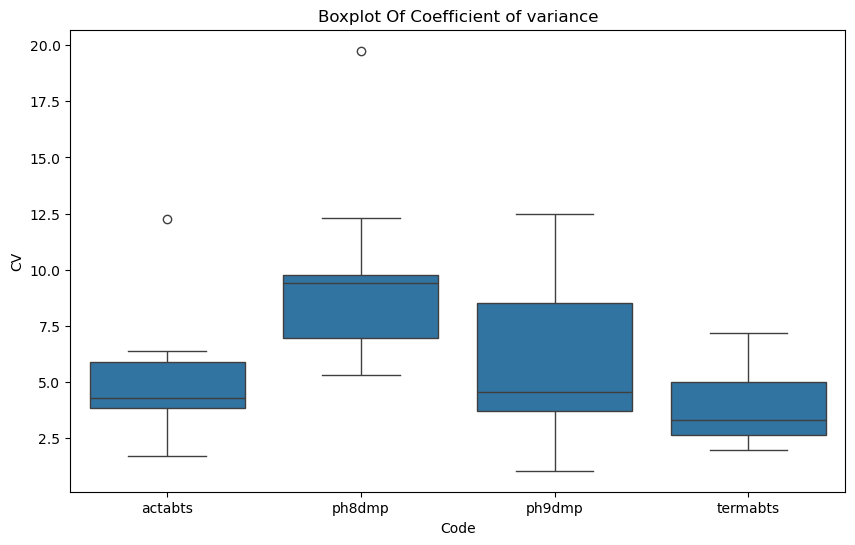

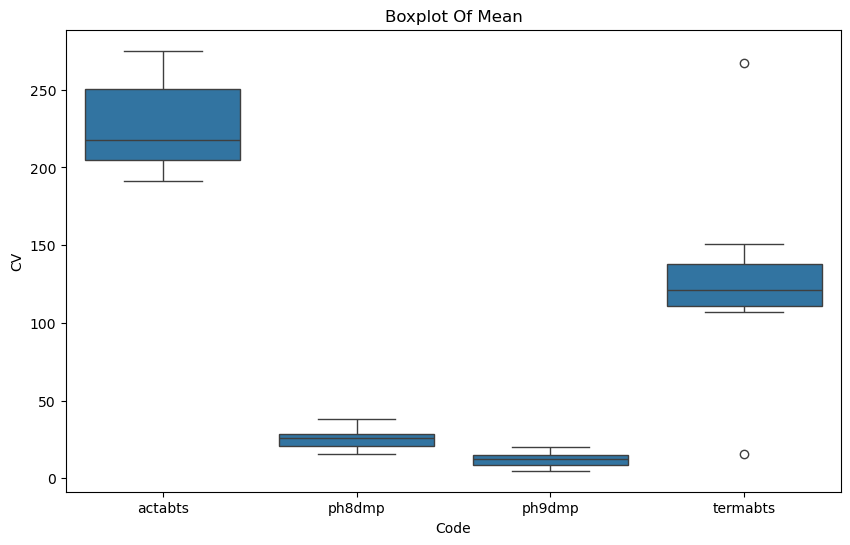

OSError: Cannot save file into a non-existent directory: 'G:\Mi unidad\Master Bioinformatica\Proyecto Screening Github\Relevant_Data_Frames'

In [29]:
#Extraction of Parental Analysis
df_test.to_excel(os.path.join(os.getcwd(),"Parental_Diagnosis","parental_diagnosis.xlsx"), index=False)

#Plot of diagnosis with code_df and df_test
df_merged=pd.merge(code_df, df_test, on="Original_Name", how="inner")
df_merged["New_Code"]=df_merged["Assay"]+df_merged["Substrate"]

#Plot of CV
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='New_Code', y='CV')
plt.title('Boxplot Of Coefficient of variance')
plt.xlabel('Code')
plt.ylabel('CV')

plt.savefig(os.path.join(os.getcwd(),"Parental_Diagnosis","CV_diagnosis.png"), format='png')


#Plot of mean
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='New_Code', y='Mean')
plt.title('Boxplot Of Mean')
plt.xlabel('Code')
plt.ylabel('CV')

plt.savefig(os.path.join(os.getcwd(),"Parental_Diagnosis","Mean_diagnosis.png"), format='png')

plt.show()


#Saving Relevant Information
df_merged.to_excel(os.path.join(os.getcwd(),"Relevant_Data_Frames","Plate_Codes.xlsx"), index=False)


## 3. Total Activity Improvement (TAI)

This section calculates the Total Activity Improvement (TAI) using selected parentals. It will create a `results` directory and a `TAI` subdirectory. The lattest contains two subdirectories:

1. **Group By Assay**: This directory will include Excel (`.xlsx`) files with all TAI analyses organized by **assay**.
2. **Group By Assay and Plate**: This directory will contain Excel (`.xlsx`) files with TAI data organized by both **assay and plate**.

Additionally, landscape plots will be included to visualize the data. The `Relevant Data_Frames` directory will contain an Excel file describing the different codes used for all plates and assays.

In [30]:
#filter df to clones
df_tai=df_extract[~df_extract['well'].str.contains('6', na=False)]


#Calculating tai
for col in df_tai.columns:
    media= df_merged[df_merged["Original_Name"]==col]
    if not media.empty:
        mean_value = media['Mean'].values[0]
        
        df_tai[col]=df_tai[col]/mean_value


C:\Users\azato\AppData\Local\Temp\ipykernel_4660\848565994.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tai[col]=df_tai[col]/mean_value


C:\Users\azato\AppData\Local\Temp\ipykernel_4660\2543280565.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


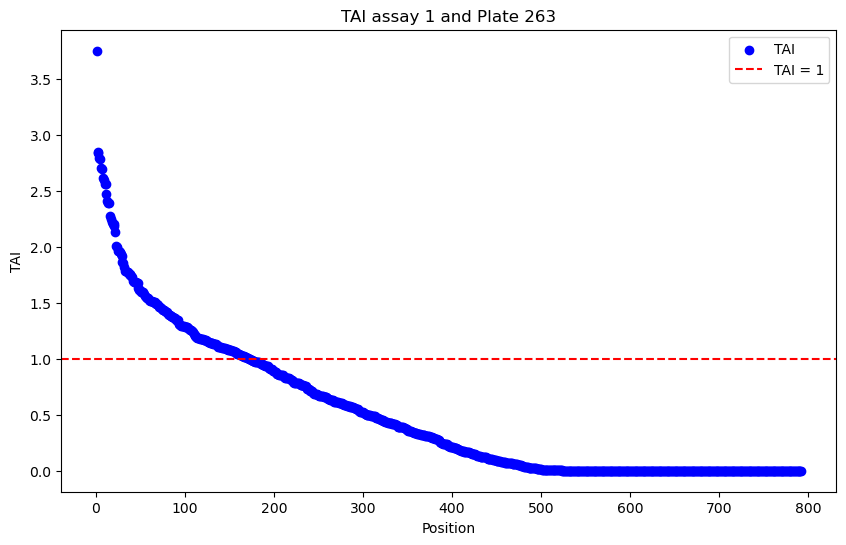

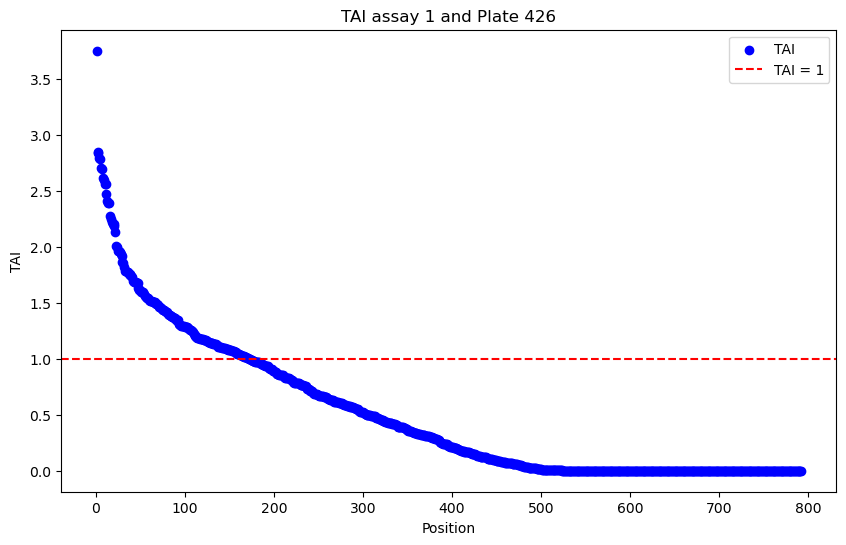

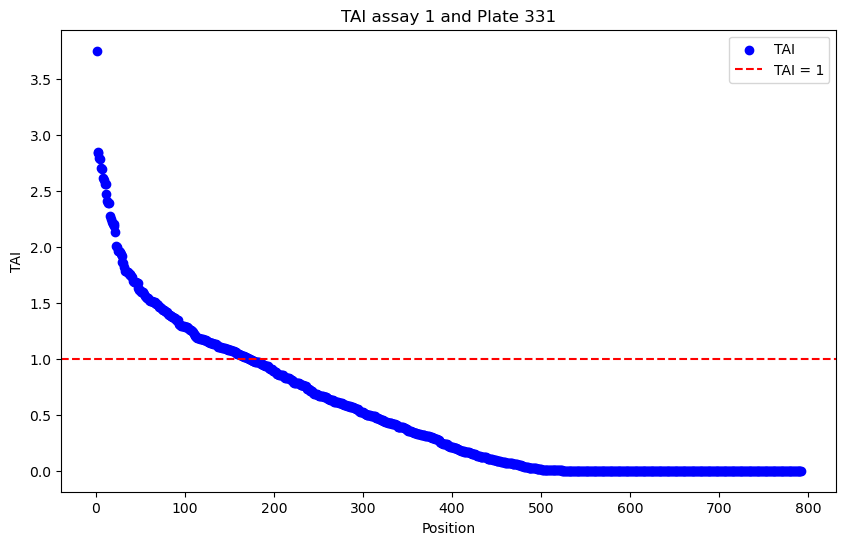

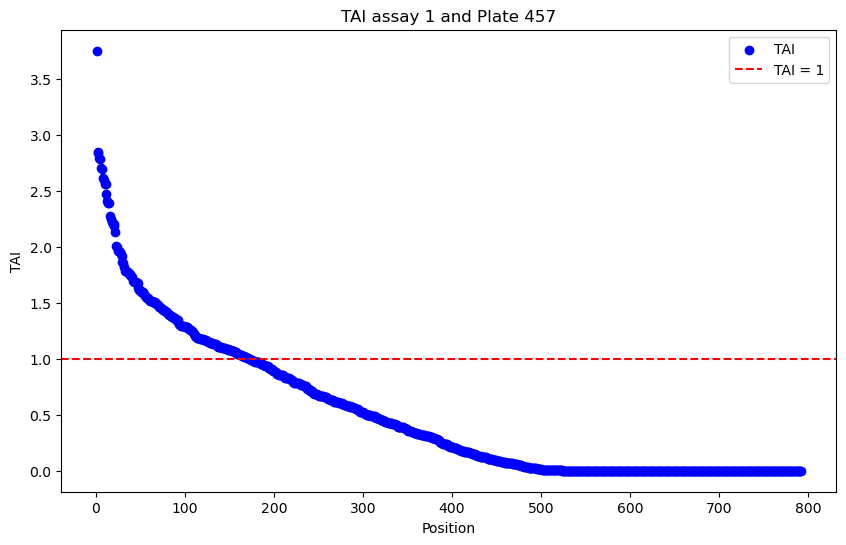

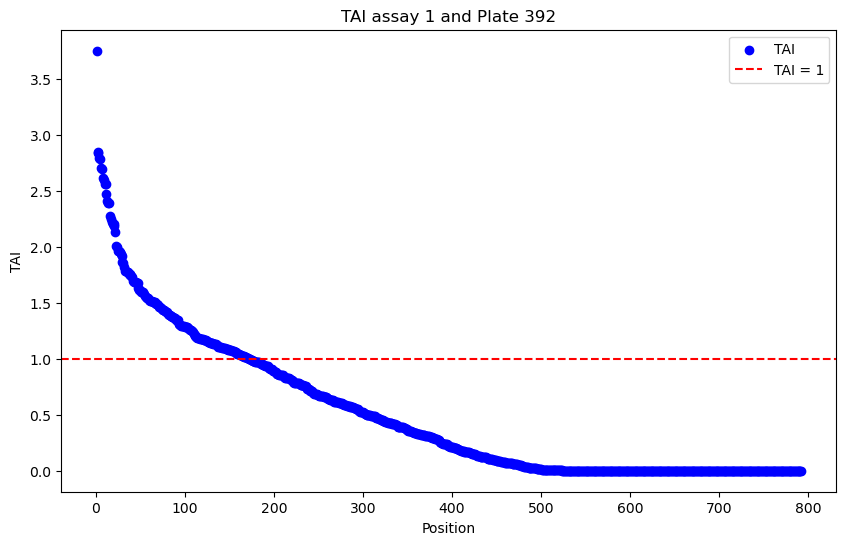

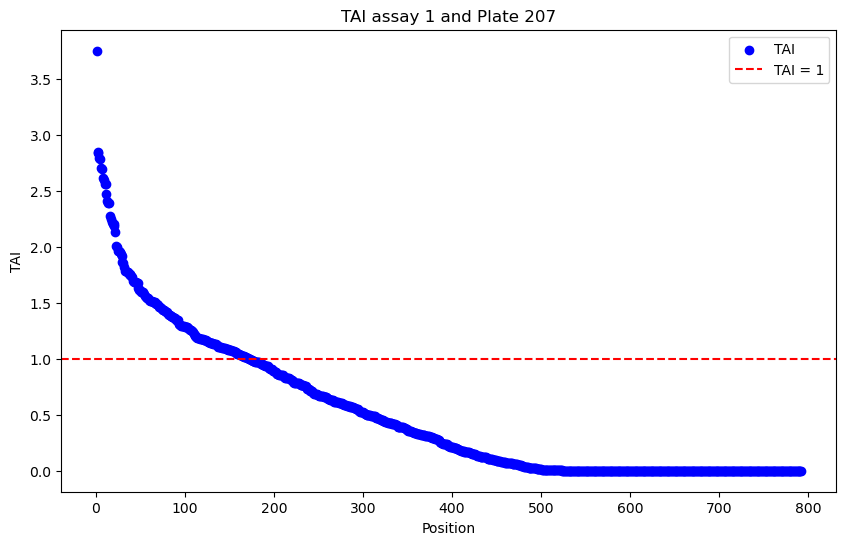

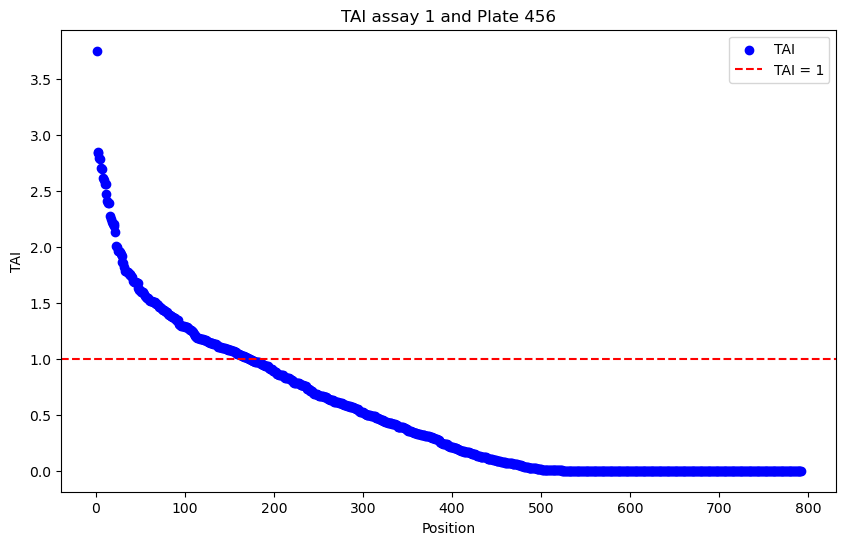

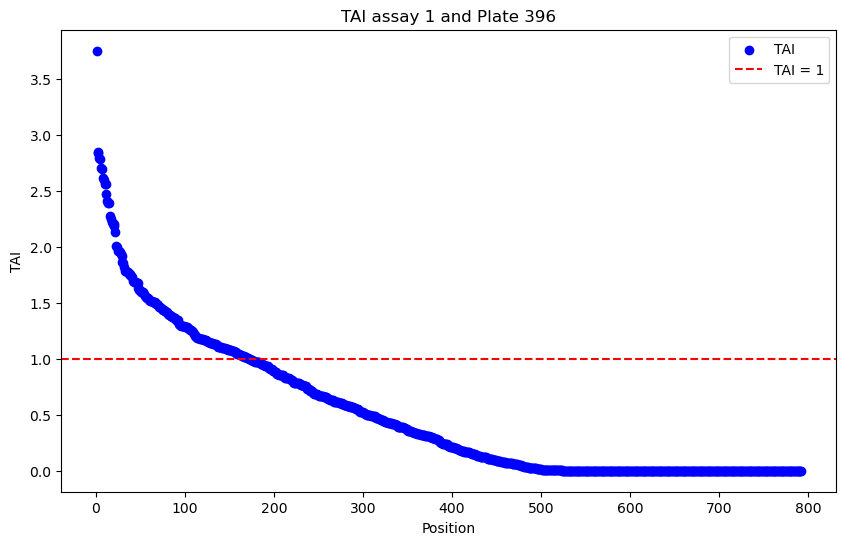

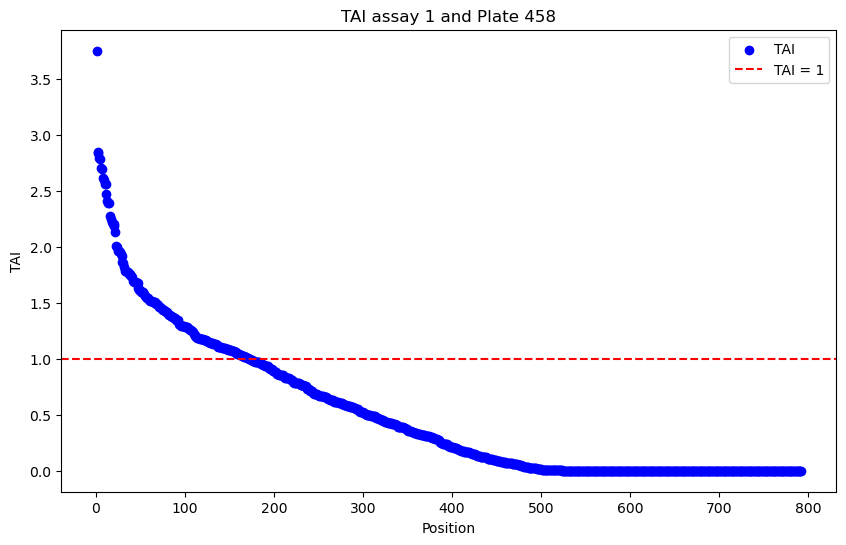

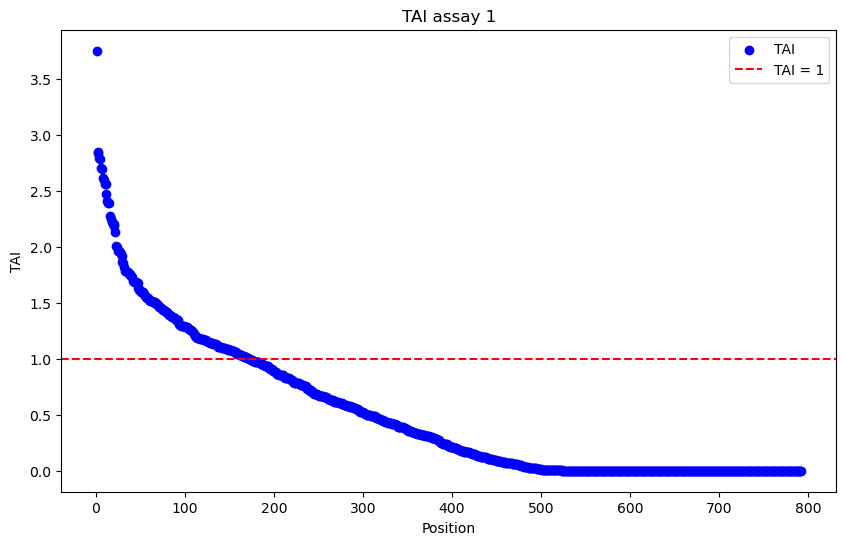

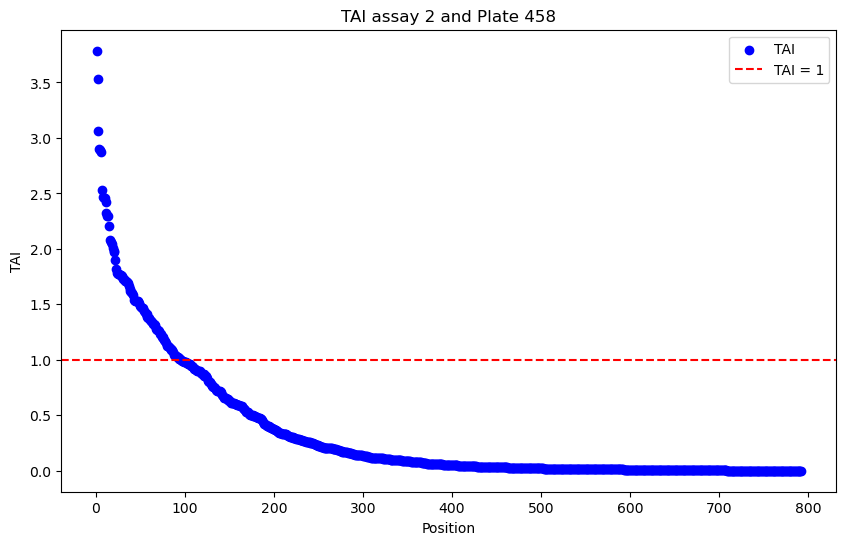

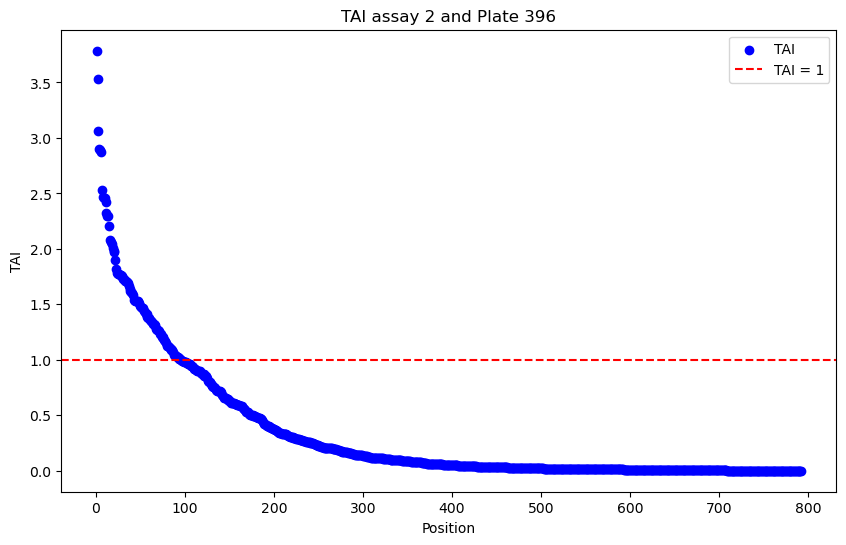

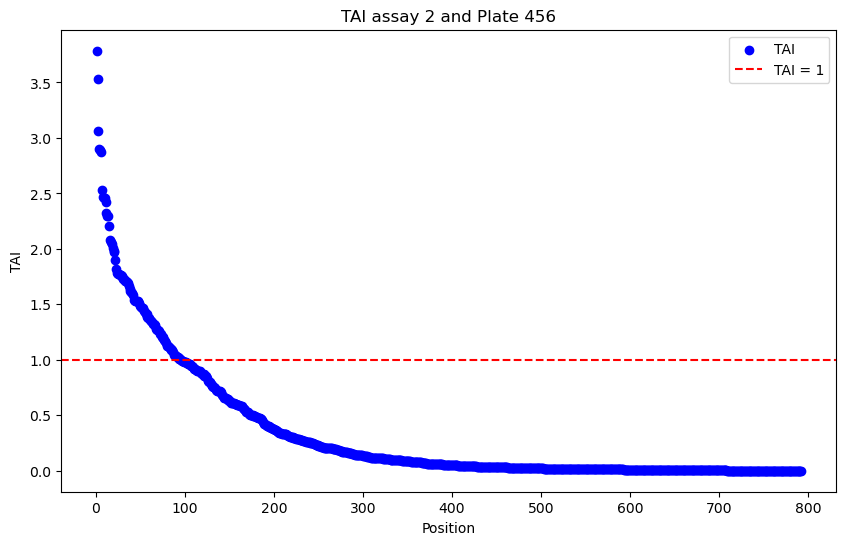

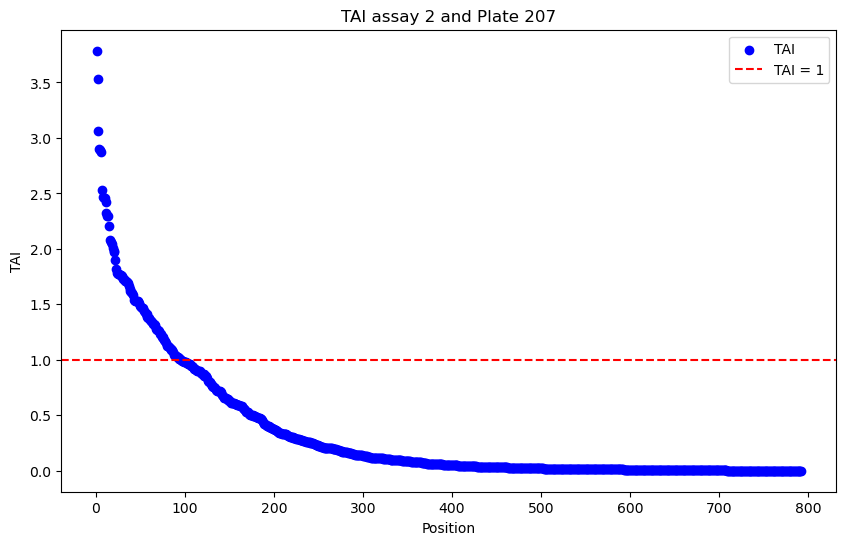

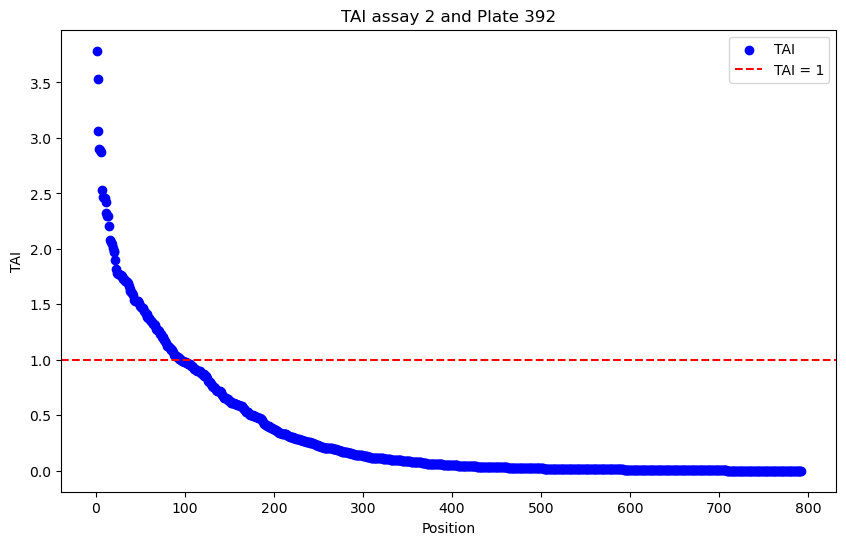

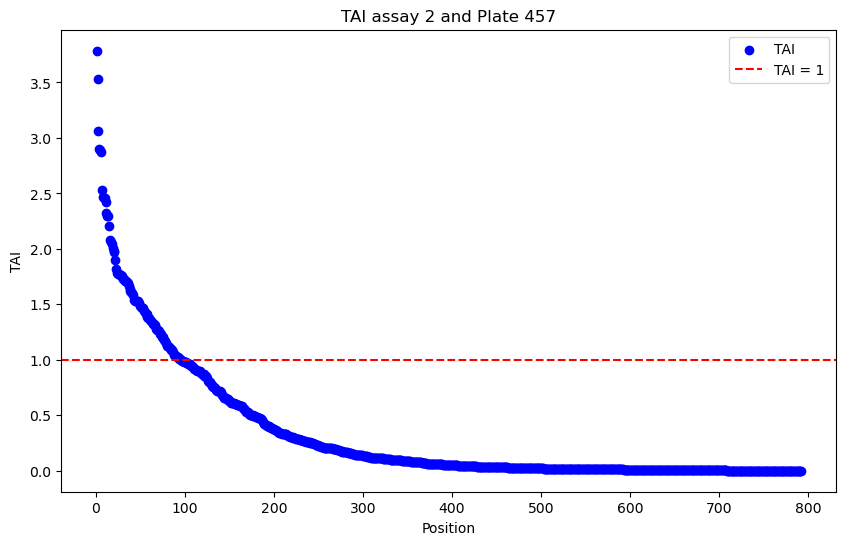

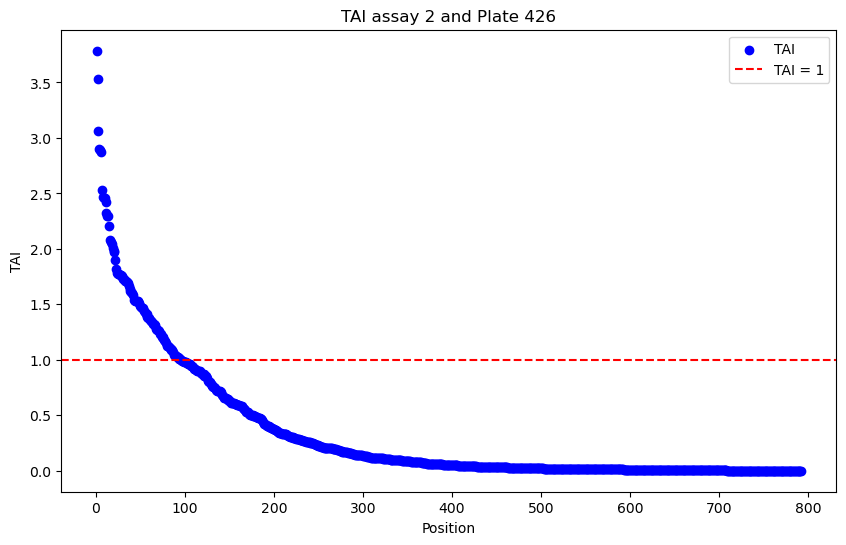

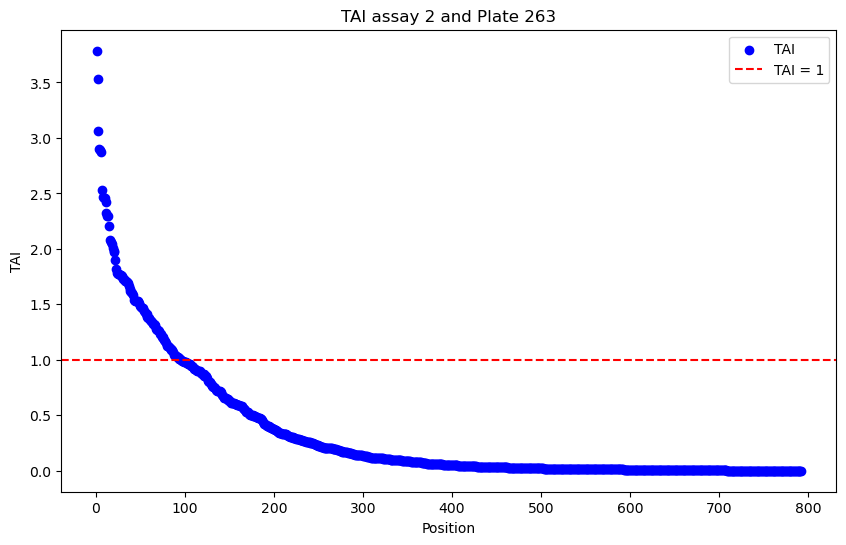

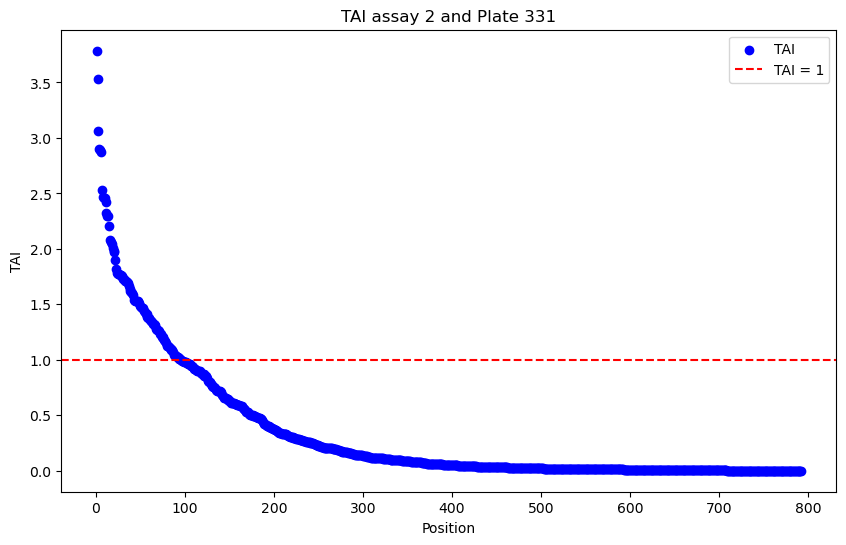

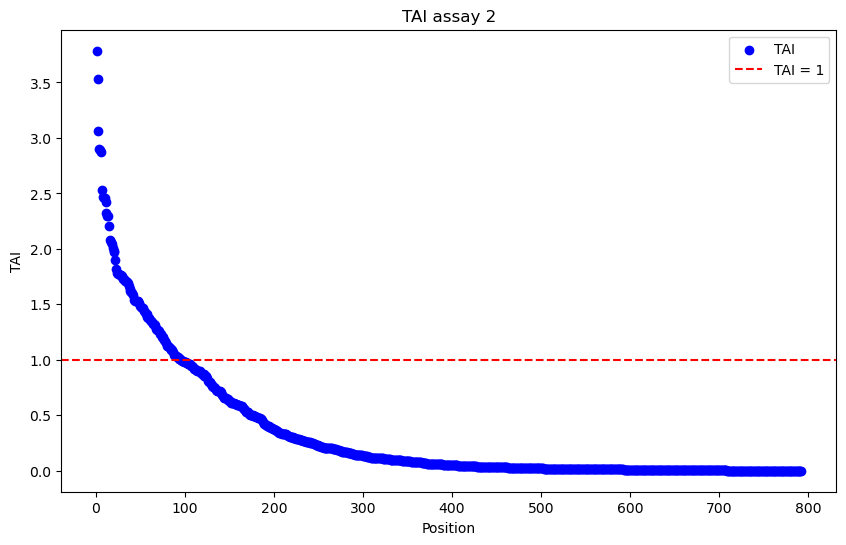

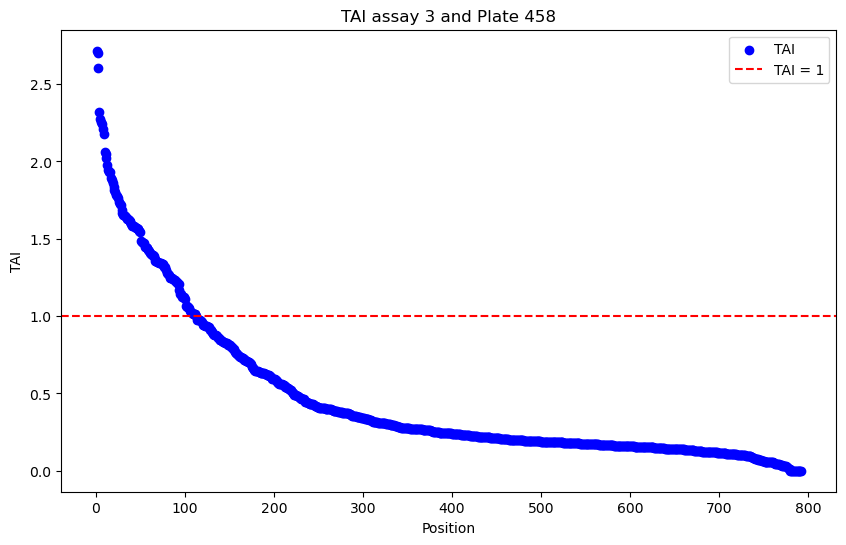

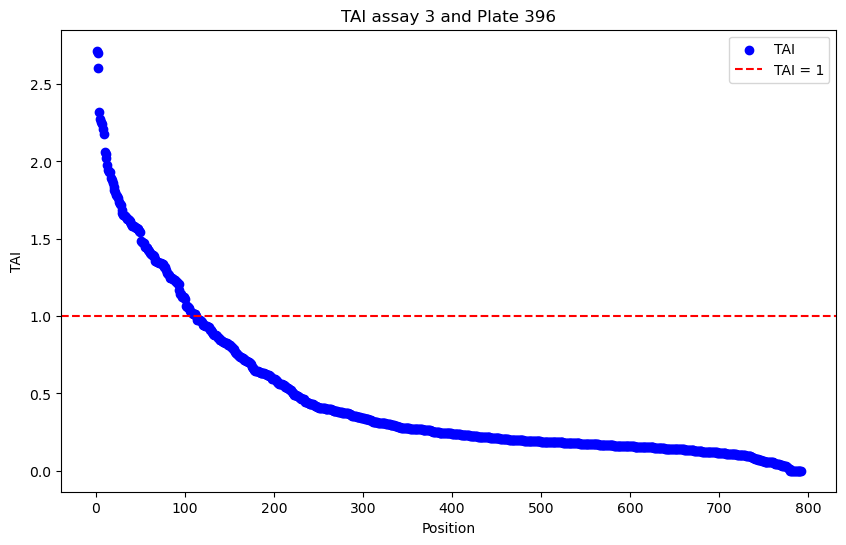

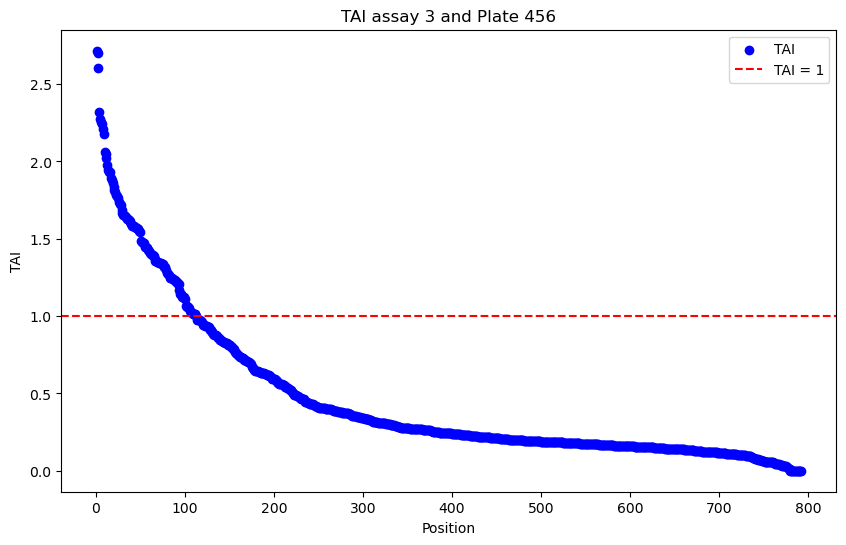

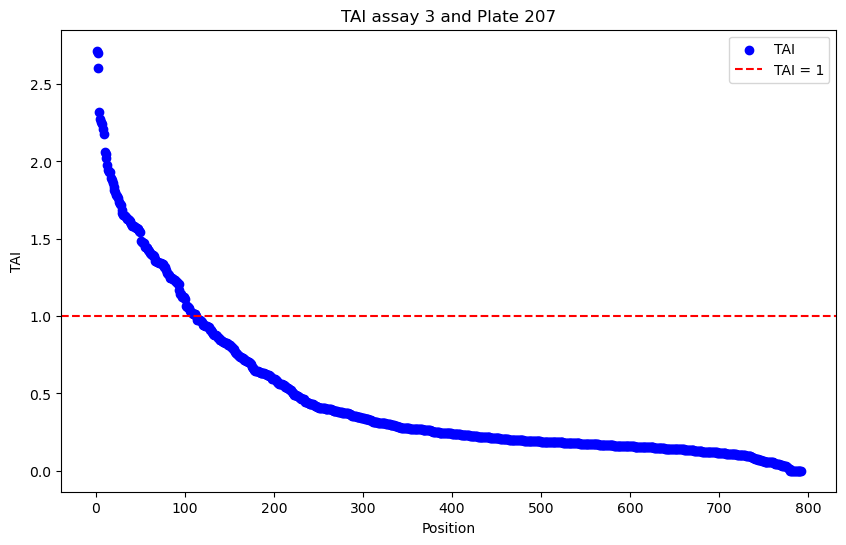

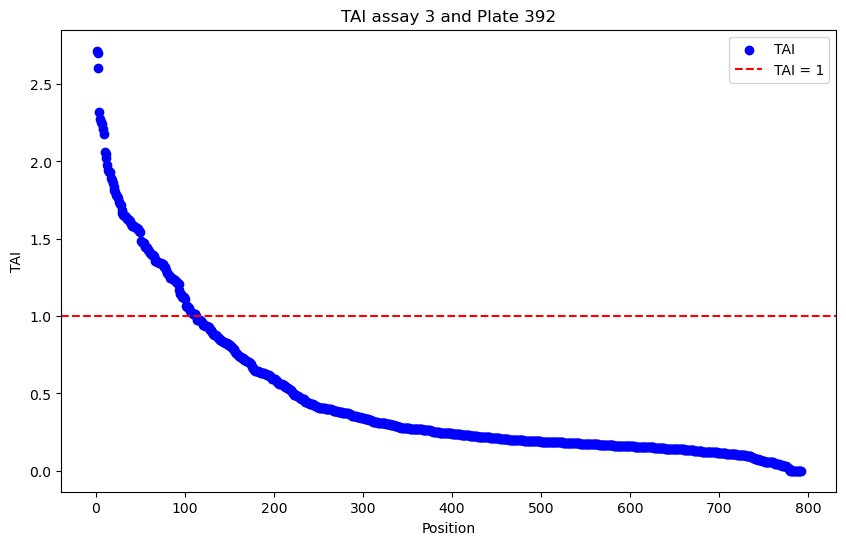

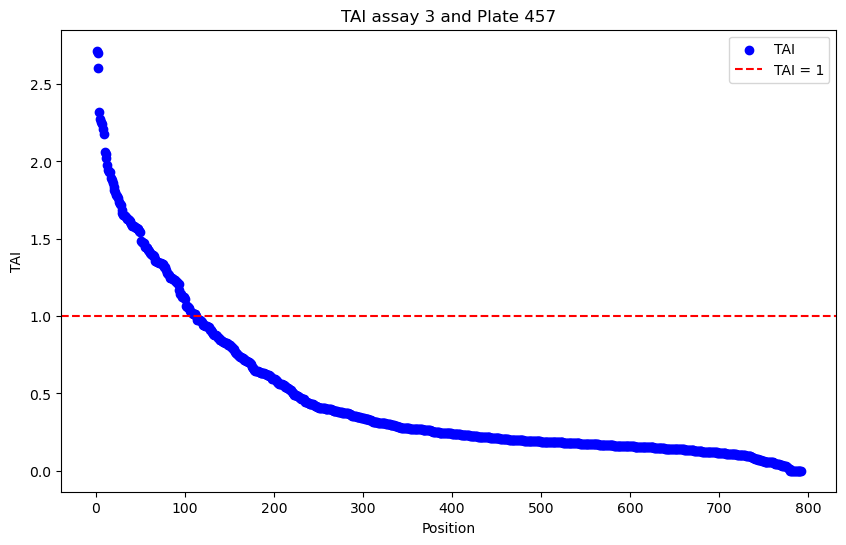

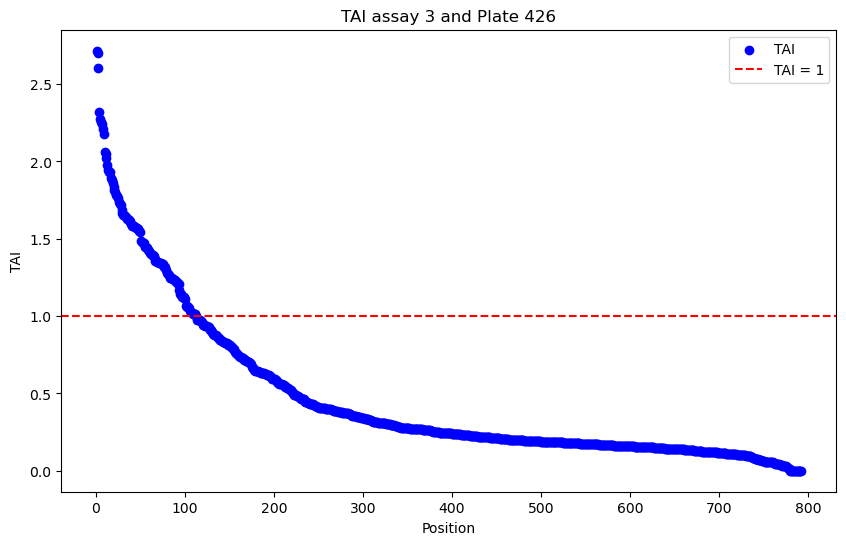

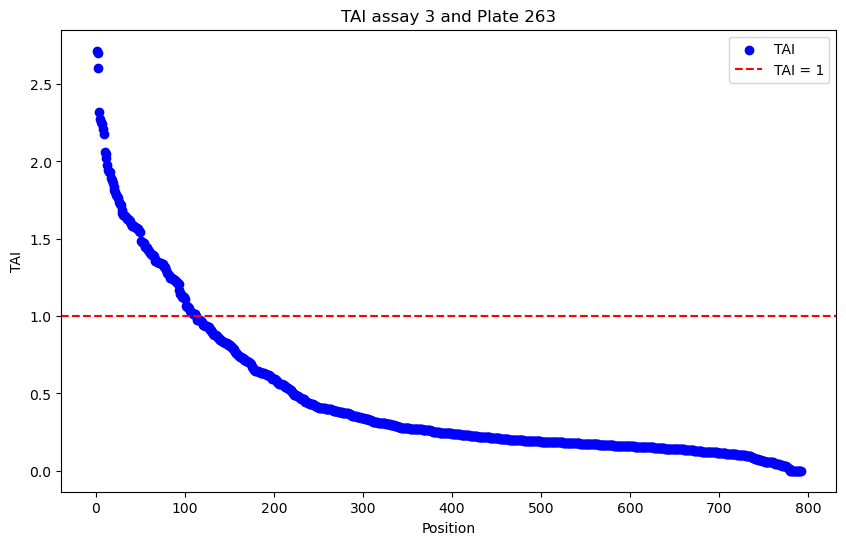

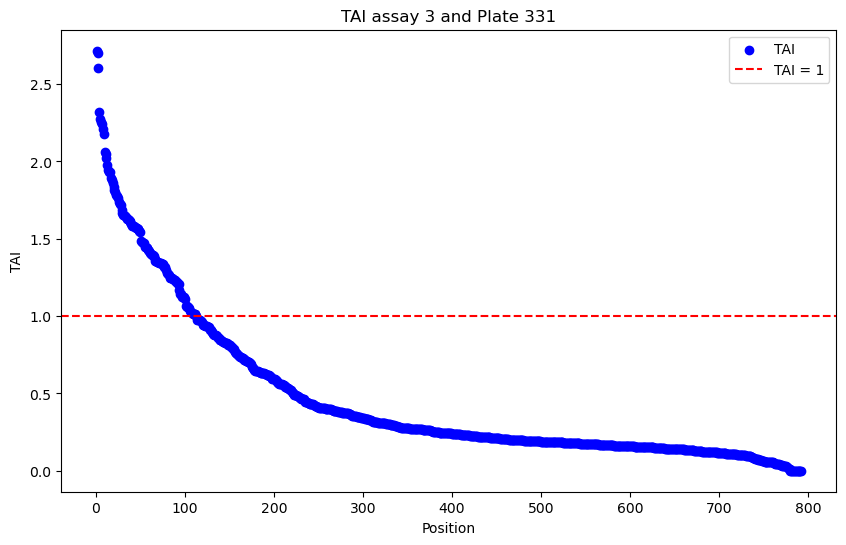

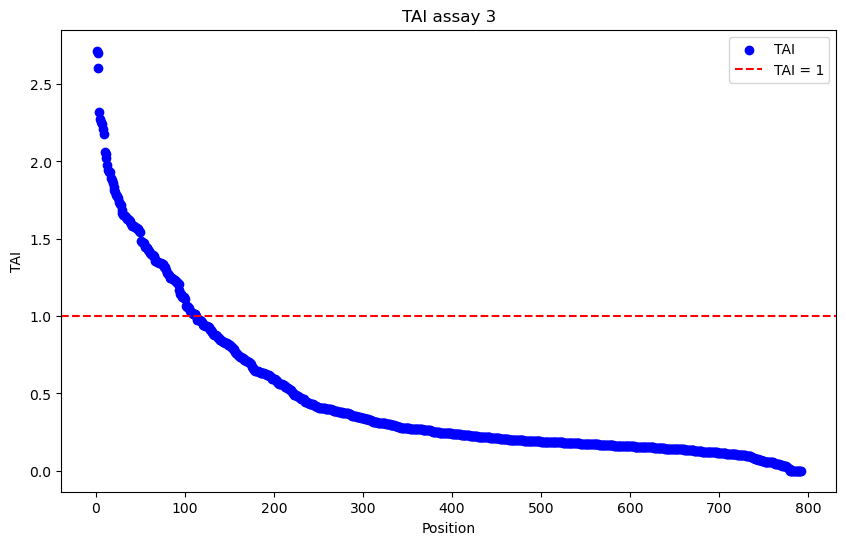

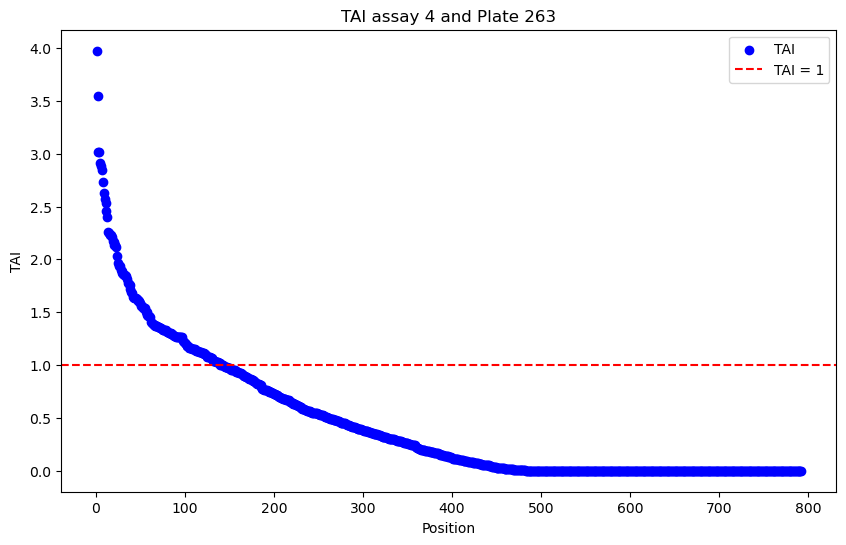

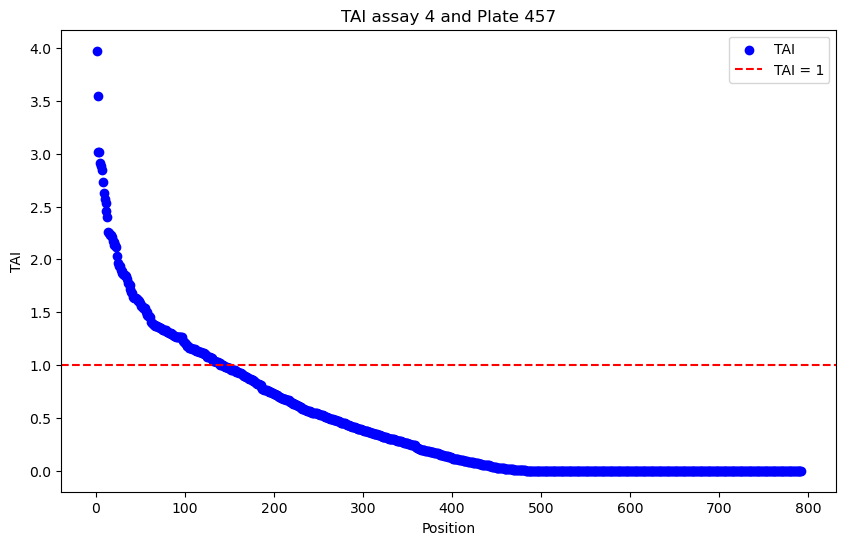

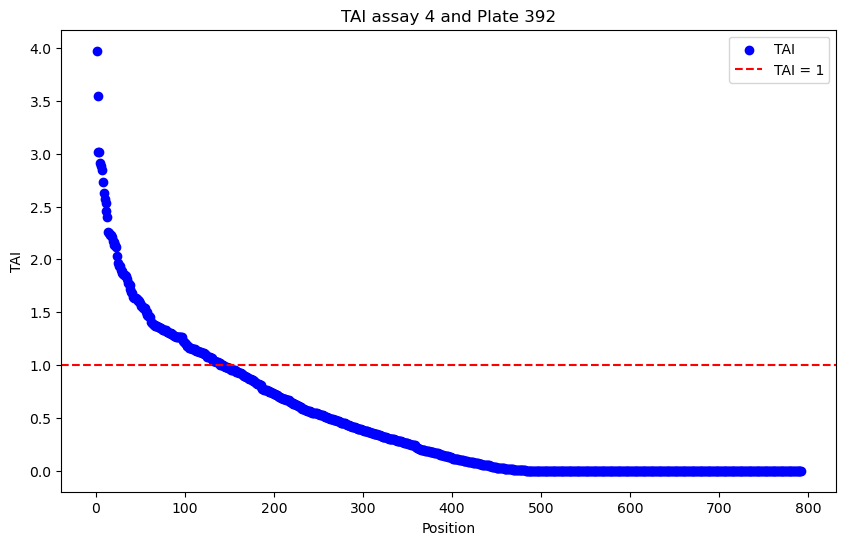

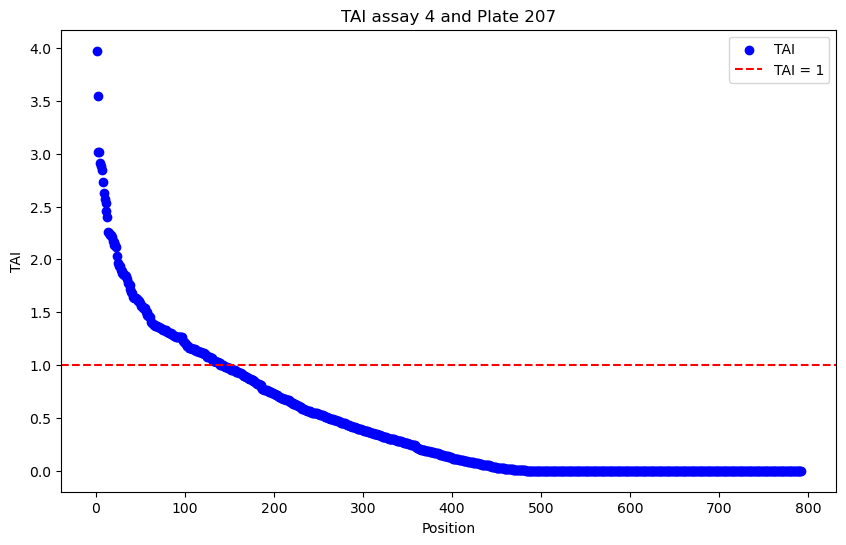

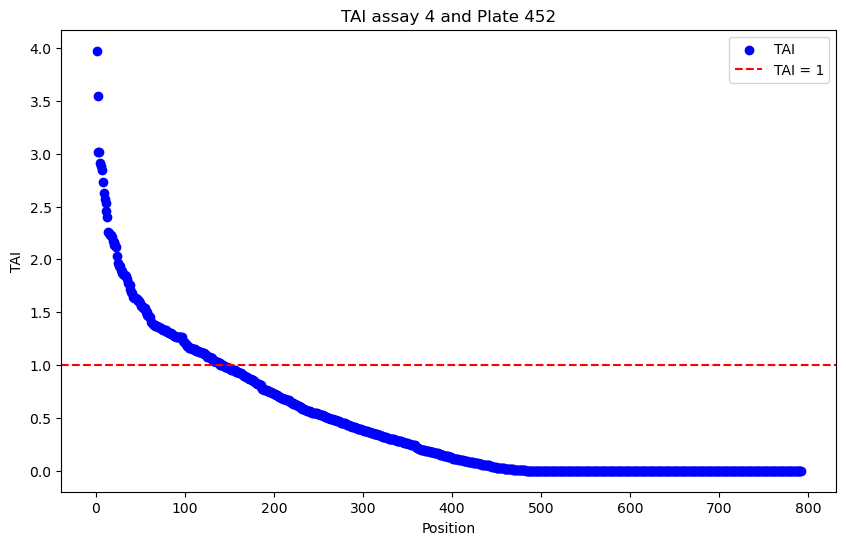

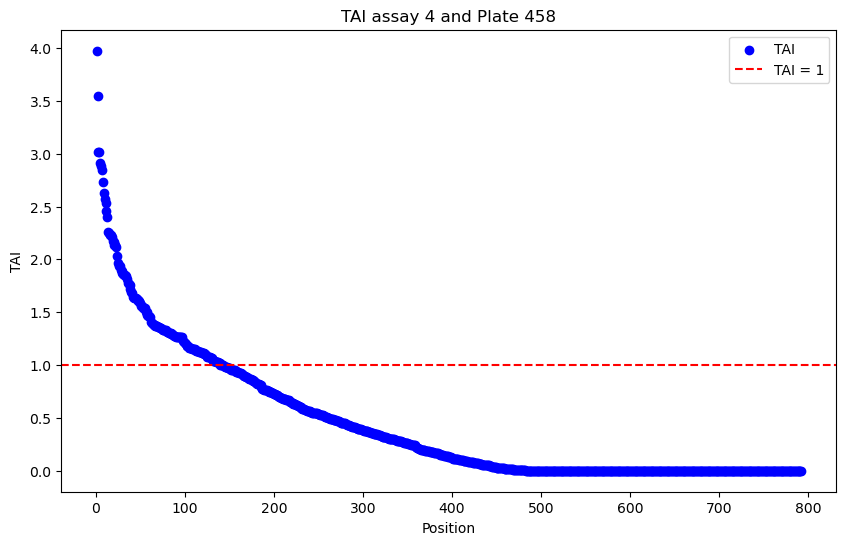

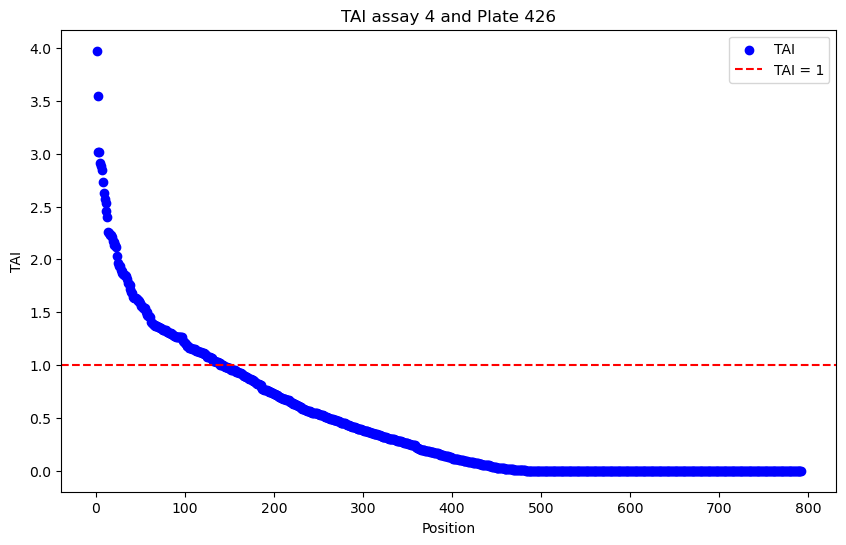

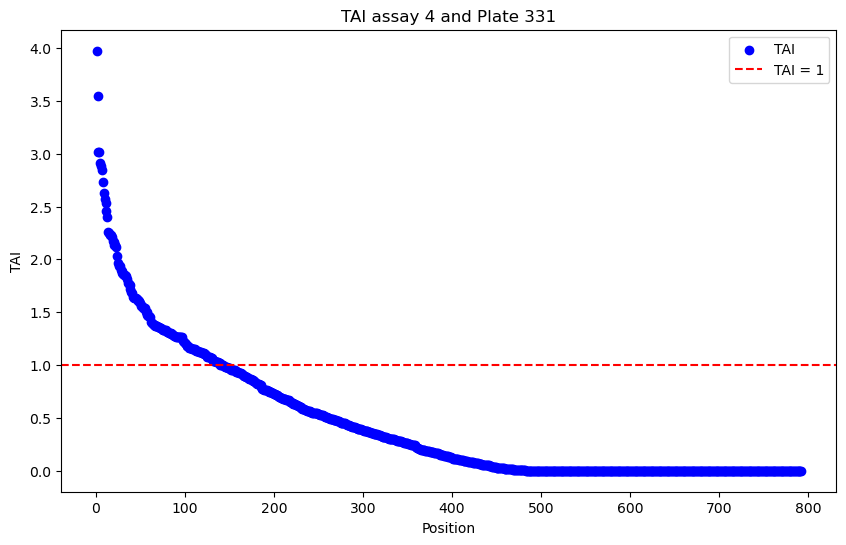

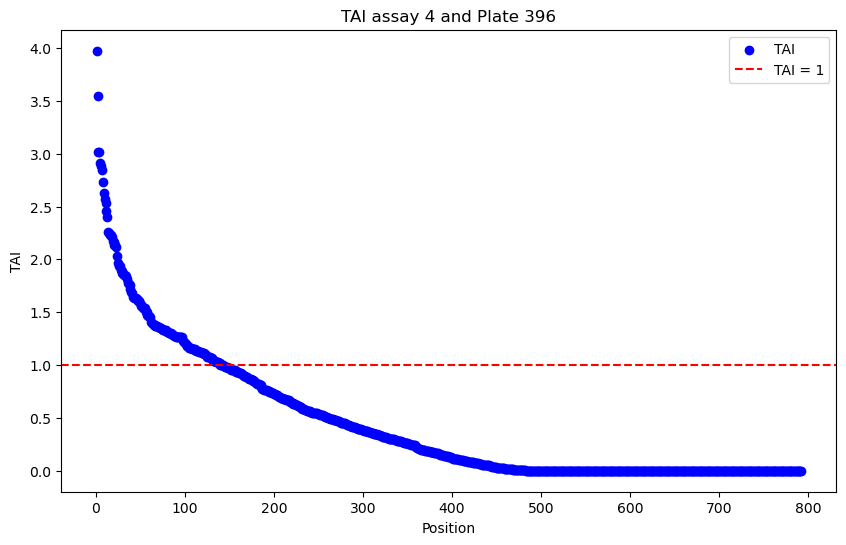

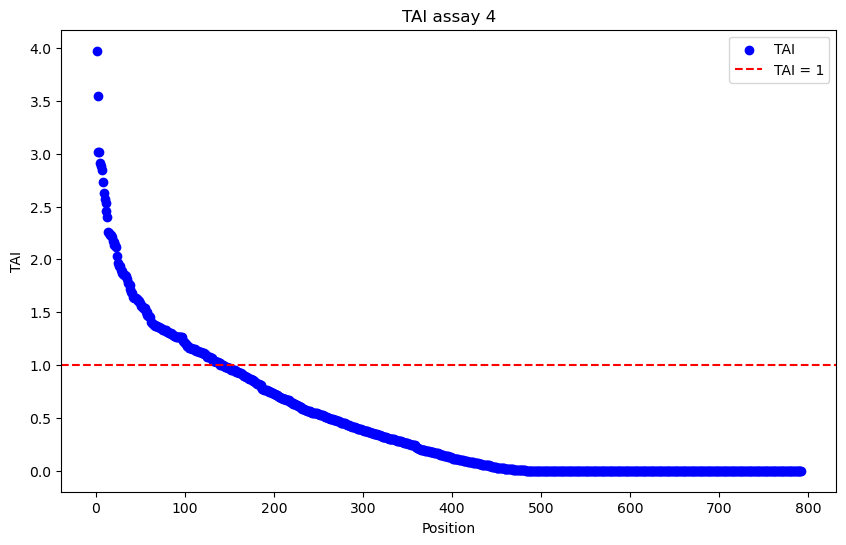

In [31]:
#Directory for the results
os.makedirs(os.path.join(os.getcwd(), "Results","TAI", "Grouped By Assay"), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), "Results", "TAI", "Grouped By Assay and Plate"), exist_ok=True)

#final df used in next chunk
df_final=pd.DataFrame({"TAI":[],"Plate_Number":[],"Well":[],"Assay":[]})


#All assays grouped
#merge by plate number and well


#Grouping by assay by code

for cod in range(1,max(df_merged["Code"]+1)):
    
    
    #Indentify names and number of plates that correspond to every code
    names=df_merged[df_merged["Code"]==cod]["Original_Name"].tolist()
    numbers=df_merged[df_merged["Code"]==cod]["Plate_Number"].tolist()
    
    #filter and add to df_result
    df_tai_code=df_tai[names]
    combined_values=[]
    number=[]
    wells=[]
    
    for col in df_tai_code.columns:
        combined_values.extend(df_tai_code[col].tolist()) #adding values
        number.extend([df_merged[df_merged["Original_Name"]==col]["Plate_Number"].values[0]] * 88) #adding plate numbers
        wells.extend(df_tai["well"].tolist()) #adding well codes
    
    #df_result grouped by Assay
    df_result=pd.DataFrame({"TAI":combined_values,"Plate_Number":number,"Well":wells})
    df_result.to_excel(os.path.join(os.getcwd(),"Results","TAI", "Grouped By Assay",f"TAI_Code_Grouped_By_Assay_{cod}.xlsx"), index=False)
    
    
    
    #final df used in next chunk
    df_final_add=pd.DataFrame({"TAI":combined_values,"Plate_Number":number,"Well":wells,"Assay":[cod]*len(number)})
    df_final=pd.concat([df_final,df_final_add], ignore_index=True)
 
    
    #df_result grouped by Assay and Plate
    for plate in numbers:
        df_result_plate=df_result[df_result["Plate_Number"]==plate]
        df_result_plate.to_excel(os.path.join(os.getcwd(),"Results","TAI","Grouped By Assay and Plate", f"TAI_Code_Grouped_By_Assay_{cod}_and_Plate_{plate}.xlsx"), index=False)
        #add positions
        df_result_plate = df_result.sort_values(by="TAI", ascending=False)
        df_result_plate["position"] = range(1, len(df_result) + 1)       
        #plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(df_result_plate["position"], df_result_plate["TAI"], color='blue', label='TAI')
        plt.axhline(y=1, color='red', linestyle='--', label='TAI = 1')
        plt.title(f'TAI assay {cod} and Plate {plate}')
        plt.xlabel('Position')
        plt.ylabel('TAI')
        plt.legend()
        plt.savefig(os.path.join(os.getcwd(),"Results","TAI", "Grouped By Assay and Plate", f"Landscape_Code_Grouped_By_Assay_{cod}_and_Plate_{plate}.png"), format='png')
        
    #Plotting
    df_result = df_result.sort_values(by="TAI", ascending=False)
    df_result["position"] = range(1, len(df_result) + 1)

    plt.figure(figsize=(10, 6))
    plt.scatter(df_result["position"], df_result["TAI"], color='blue', label='TAI')
    plt.axhline(y=1, color='red', linestyle='--', label='TAI = 1')
    plt.title(f'TAI assay {cod}')
    plt.xlabel('Position')
    plt.ylabel('TAI')
    plt.legend()
    plt.savefig(os.path.join(os.getcwd(),"Results","TAI", "Grouped By Assay", f"Landscape_Code_Grouped_By_Assay_{cod}.png"), format='png')
    


In [32]:
#Directory for the results
os.makedirs(os.path.join(os.getcwd(), "Results", "Comparison"), exist_ok=True)

## 4. Comparison

This section performs queries to calculate TAIs based on absorbance increments, making one-by-one comparisons. Cells must be run again from this point to conduct a new comparison. This is useful when you want to compare how same well/clone behaves in two Assay conditions

The script will prompt the user to:
- Choose between comparison by assay or by plate
- Establish a TAI threshold. Low absorbance activity should be considered as 0 (recommended <6)
- Specify which assays/conditions will be evaluated

In the `Results` directory, a new `Comparison` subdirectory will be created to include the new results in `.xlsx` format.


In [33]:
while True:
    # Ask the user whether they want to compare by assays or by plates
    print("Do you want to compare by assays (all plate numbers come from the same parental/library) or by plates?")
    format_input = input("Please type 'yes' for Assays or 'no' for Plates: ").strip().lower()

    if format_input in ['yes', 'y', 'true']:
        format = "Assay"
        print("Plate numbers are not considered relevant for comparison. All plates are considered to belong to the same library.")
        break
    else:
        format = "Plate_Number"
        print("Each Plate_Number is considered an independent library.")
        break

while True:
    # Ask the user whether they want to establish a threshold
    print("Screenings with low activity (Abs/min) can be misleading. It is recommended to establish an activity threshold below which every measurement is considered as 0.")
    confirm = input("Do you want to establish a threshold? (yes/no): ").strip().lower()

    if confirm in ['yes', 'y', 'true']:
        while True:
            try:
                threshold = float(input("Numeric Threshold (5 is recommended): ").strip())
                print(f"Threshold set to {threshold}")
                break
            except ValueError:
                print("Invalid input. Please enter a numeric value.")
        break
    else:
        threshold = None
        print("No threshold set.")
        break
        
        


Do you want to compare by assays (all plate numbers come from the same parental/library) or by plates?


Please type 'yes' for Assays or 'no' for Plates:  y


Plate numbers are not considered relevant for comparison. All plates are considered to belong to the same library.
Screenings with low activity (Abs/min) can be misleading. It is recommended to establish an activity threshold below which every measurement is considered as 0.


Do you want to establish a threshold? (yes/no):  y
Numeric Threshold (5 is recommended):  7


Threshold set to 7.0


In [35]:
# Query for Comparisons
print("The codes for comparisons are:")
print(code_dict)

while True:
    comp_parental = input("Please enter the code of the assay you want to use as the reference: ").strip()
    confirm = input(f"Is Assay {comp_parental} the reference? (yes/no): ").strip().lower()
    
    if confirm in ['yes', 'y', 'true']:
        comp = input(f"Please enter the code of the assay you want to compare with the reference assay {comp_parental}: ").strip()
        confirm = input(f"Is Assay {comp} the one to be compared? (yes/no): ").strip().lower()
        
        if confirm in ['yes', 'y', 'true']:
            print(f"Reference Assay: {comp_parental}")
            print(f"Assay to be compared: {comp}")
            break
        else:
            print("Please re-enter the code of the assay to be compared.")
            continue
    else:
        print("Please re-enter the code of the reference assay.")
        continue


The codes for comparisons are:
{('abts', 'act'): 1, ('dmp', 'ph8'): 2, ('dmp', 'ph9'): 3, ('abts', 'term'): 4}


Please enter the code of the assay you want to use as the reference:  2
Is Assay 2 the reference? (yes/no):  y
Please enter the code of the assay you want to compare with the reference assay 2:  4
Is Assay 4 the one to be compared? (yes/no):  y


Reference Assay: 2
Assay to be compared: 4


In [39]:
#Directory for the results
os.makedirs(os.path.join(os.getcwd(), "Results", "Comparison",f"Assay_{comp}_respect to Assay_{comp_parental}"), exist_ok=True)


#Generate a DF_comparison that includes the parental in column 6
df_comparison=df_extract.copy()

#final df used in next chunk
df_final=pd.DataFrame({"Absorbance":[],"Plate_Number":[],"Well":[],"Assay":[]})

#Grouping by assay by code

for cod in range(1,max(df_merged["Code"]+1)):
    
    
    #Indentify names and number of plates that correspond to every code
    names=df_merged[df_merged["Code"]==cod]["Original_Name"].tolist()
    numbers=df_merged[df_merged["Code"]==cod]["Plate_Number"].tolist()
    
    #filter and add to df_result
    df_tai_code=df_comparison[names]
    combined_values=[]
    number=[]
    wells=[]
    
    for col in df_tai_code.columns:
        combined_values.extend(df_tai_code[col].tolist()) #adding values
        number.extend([df_merged[df_merged["Original_Name"]==col]["Plate_Number"].values[0]] * 96) #adding plate numbers
        wells.extend(df_comparison["well"].tolist()) #adding well codes
    
    #df_result grouped by Assay
    print(len(wells))
    df_result=pd.DataFrame({"Absorbance":combined_values,"Plate_Number":number,"Well":wells})
    
    #final df used in next chunk
    df_final_add=pd.DataFrame({"Absorbance":combined_values,"Plate_Number":number,"Well":wells,"Assay":[cod]*len(number)})
    df_final=pd.concat([df_final,df_final_add], ignore_index=True)

    



#"," to "." for decimals
df_final['Absorbance'] = df_final['Absorbance'].apply(lambda x: str(x).replace(",", "."))

#to numeric
df_final['Absorbance'] = pd.to_numeric(df_final['Absorbance'], errors='coerce')

#apply treshold
if isinstance(threshold, (int, float, np.number)):
    df_final['Absorbance'] = df_final['Absorbance'].apply(lambda x: 0 if pd.notna(x) and x <= threshold else x)



864
864
864
864


In [41]:
# Anwser Query


#Filter by assay
df_final_filter=df_final[(df_final["Assay"]==int(comp)) | (df_final["Assay"]==int(comp_parental))]

#Comparison TAI relative

#New Id based on Plate_Number and Well
df_final_filter["Id"]=df_final_filter["Plate_Number"]+df_final_filter["Well"]

#split df into 2 based on assay and calculate TAI
df_final_filter_parental=df_final_filter[df_final_filter["Assay"]==int(comp_parental)]
df_final_filter_test=df_final_filter[df_final_filter["Assay"]==int(comp)]
df_final_filter=pd.merge(df_final_filter_parental,df_final_filter_test,on="Id",how="inner")

df_final_filter["TAI_normalized"] = np.where(
    df_final_filter["Absorbance_x"] != 0,
    df_final_filter["Absorbance_y"] / df_final_filter["Absorbance_x"],
    0)

#Rename columns
df_final_filter.rename(columns={"Well_x":"well"},inplace=True)

#Extract plates numbers of the assay

plates=df_final_filter.drop_duplicates(subset=["Plate_Number_x"])["Plate_Number_x"].tolist() #Plate Numbers

#Extract parentals

#Filter TAI_normalized and Plate number of parentals
df_final_filter_parental = df_final_filter[df_final_filter['well'].str.contains(r'6', regex=True)][["TAI_normalized","Plate_Number_x"]]

#Applying mean function to every plate to calculate parentals

results_list = []

for plate in plates:
    placa=df_final_filter_parental[df_final_filter_parental["Plate_Number_x"] == str(plate)]["TAI_normalized"].tolist()
    mean_value, cv_value, parentals_value = mean(placa)
    result_row = [mean_value, cv_value, parentals_value, plate]
    results_list.append(result_row)

df_results = pd.DataFrame(results_list, columns=["Mean", "CV", "Parentals", "Plate"])



#Prepare data for TAI respecto to parental

df_final_filter["TAI_Respect_To_Parental"]=[np.nan]*df_final_filter.shape[0]
df_final_filter["TAI_Respect_To_Parental"] = df_final_filter["TAI_Respect_To_Parental"].astype(float)
df_results["Mean"] = df_results["Mean"].astype(float)
df_final_filter["TAI_normalized"] = df_final_filter["TAI_normalized"].astype(float)

#Calculate TAI respect to the Parental in column 6
for plate in plates:
    # Seleccionar el valor parental (esperado como un solo valor)
    value_parental = df_results[df_results["Plate"] == plate]["Mean"].values[0]
    print(value_parental)
    # Seleccionar los valores a normalizar
    value_to_be_normalized = df_final_filter.loc[df_final_filter["Plate_Number_x"] == str(plate), "TAI_normalized"]
    print(value_to_be_normalized)
    # Aplicar la lógica de asignación usando .loc para asegurar que se modifique el DataFrame original
    df_final_filter.loc[df_final_filter["Plate_Number_x"] == str(plate), "TAI_Respect_To_Parental"] = np.where(
        value_parental == 0,
        "Parental was 0",
        value_to_be_normalized / value_parental
    )




#Export data TAI between assays or assays+plate number
#Among Assays
if format=="Assay":
    df_export_comp=df_final_filter[["well","Plate_Number_x","TAI_normalized","TAI_Respect_To_Parental"]]
    df_export_comp.to_excel(
    os.path.join(
        os.getcwd(),
        "Results",
        "Comparison",
        f"Assay_{comp}_respect to Assay_{comp_parental}",
        f"TAI_Parental{comp_parental}_clon{comp}.xlsx"
    ),
    index=False
)    
#Assays+Plates    
else:
    df_export_comp=df_final_filter[["well","Plate_Number_x","TAI_normalized","TAI_Respect_To_Parental"]]
    
    for plate in plates:
        df_filtered = df_export_comp[df_export_comp["Plate_Number_x"] == plate]
        file_name = f"TAI_By_Assay and Plate{plate}_Parental{comp_parental}_clon{comp}.xlsx"
        file_path = os.path.join(
    os.getcwd(),
    "Results",
    "Comparison",
    f"Assay_{comp}_respect to Assay_{comp_parental}",
    file_name
)
        df_filtered.to_excel(file_path, index=False)

# Define the file path
file_path = os.path.join(
    os.getcwd(),
    "Results",
    "Comparison",
    f"Assay_{comp}_respect to Assay_{comp_parental}",
    "Parental Diagnosis.xlsx"  # Ensure to include the file extension
)

# Save the DataFrame to an Excel file
df_results.to_excel(file_path, index=False)

#Saving Relevant Information
code_dict_df .to_excel(os.path.join(os.getcwd(),"Relevant_Data_Frames","Assays_Codes.xlsx"), index=False)

print("if you want to make new comparison run again from point 4")

C:\Users\azato\AppData\Local\Temp\ipykernel_4660\2566496120.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_filter["Id"]=df_final_filter["Plate_Number"]+df_final_filter["Well"]
C:\Users\azato\AppData\Local\Temp\ipykernel_4660\2566496120.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1.0769868569636505' '0.0' '1.4805790725543144' '0.9007065097576319'
 '0.7172307295318499' '1.9064547786509758' '0.7350725801664777' '0.0'
 '3.5796728701396874' '1.3411722580806744' '0.8524423666572601' '0.0'
 '1.22947014203512' '0.0' '0.0' '0.9133246312308811' '0.9121377105378613'
 '1.2675422742548146' '0.0' '0.0' '0.0' '0.679289769947377' '0.0'
 '0.681632712565479

3.968170901591049
0      4.273668
1      0.000000
2      5.875191
3      3.574157
4      2.846094
        ...    
91    14.561003
92     4.519895
93     3.593561
94     0.000000
95     4.609182
Name: TAI_normalized, Length: 96, dtype: float64
8.921443981575209
96      0.000000
97      0.000000
98      0.000000
99      0.000000
100     0.000000
         ...    
187     0.000000
188     0.000000
189    12.706203
190     0.000000
191     0.000000
Name: TAI_normalized, Length: 96, dtype: float64
3.096314620425536
192    2.775794
193    0.000000
194    0.000000
195    2.603826
196    3.946336
         ...   
283    0.000000
284    7.041822
285    3.671864
286    0.000000
287    0.000000
Name: TAI_normalized, Length: 96, dtype: float64
4.074540545521435
288    0.000000
289    0.000000
290    5.201468
291    0.000000
292    0.000000
         ...   
379    0.000000
380    0.000000
381    0.000000
382    0.000000
383    0.000000
Name: TAI_normalized, Length: 96, dtype: float64
4.574190379581543

OSError: Cannot save file into a non-existent directory: 'G:\Mi unidad\Master Bioinformatica\Proyecto Screening Github\Relevant_Data_Frames'